# Relatedness
## Tara iti relationships
Relatedness estimates were used to examine pedigree relationships and inform sample selection for downstream analyses as it is important to mitigate the consequences of bias in sampleing family groups in the tara iti population. However, it is important to note that the tara iti population has been small for several generations, and likely has multiple generational backcrossing events as breeding individuals are generally long-lived (e.g., 10-15 years). 

Accurately inferring relatedness from whole-genome sequencing data is challenging in small, likely inbred populations. To address this, we are utilising the R<sub>ab</sub> and KING based estimators of relatedness as they have been shown to perform well when inferring true relationships in small populations ([Hauser et al. 2022](https://doi.org/10.1111/1755-0998.13630)).  

Estimating relatedness is a two step process where we first estimate genotype likelihoods with ANGSD, then estimating R<sub>AB</sub> and KING with ngsRelate. We filtered for sites that were present in all 54 individuals, biallelic, a minimu mean depth of 6x per individual and a maximum mean depth of 33x per individual. Reads also had to have a minimum mean quality score and mapping score of 20 to be included in calculations. 

In [ ]:
angsd -P 32 -b ${ANGSD}${POP}.list -ref ${REF} -out ${ANGSD}samtools/relatedness/${POP} \
    -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 -minMapQ 20 -minQ 20 \
    -minInd 54 -setMinDepth 324 -setMaxDepth 1782 \
    -doCounts 1 -doMajorMinor 1 -GL 1 -doMaf 1 -skipTriallelic 1 -SNP_pval 1e-6 -doGlf 3

zcat ${ANGSD}samtools/relatedness/${POP}.mafs.gz | cut -f6 | sed 1d > ${ANGSD}samtools/relatedness/${POP}_whole-genome_freq

ngsRelate -g ${ANGSD}samtools/relatedness/${POP}.glf.gz \
    -n ${NINDIV} -f ${ANGSD}samtools/relatedness/${POP}_whole-genome_freq \
    -z ${ANGSD}${POP}_realatedness_IDs.txt \
    -O ${ANGSD}samtools/relatedness/${POP}_whole-genome_relatedness

A total of 424,636 sites out of 1,195,028,924 analysed sites were retained after filtering and used as input for ngsRelate.  The output of ngsRelate

### Visualisation of tara iti relatedness
First, we import outputs from ngsRelate and transform them into matrices for each specific estimator.  

In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.legend_handler import HandlerTuple

path = '/nesi/nobackup/uc03718/'
os.chdir(path)
print(os.getcwd())

/nesi/nobackup/uc03718


In [2]:
# Read and process your data
TI_wg = pd.read_csv('angsd/samtools/relatedness/TI_whole-genome_relatedness', sep='\t')
TI_full = pd.concat([TI_wg, TI_wg.rename(columns={'ida': 'idb', 'idb': 'ida'})])

# Create pivots
TI_wg_Rab = TI_full.pivot(index='ida', columns='idb', values='rab')
TI_wg_KING = TI_full.pivot(index='ida', columns='idb', values='KING')

# Filter for first order relationships. 
TI_first_Order_Rab = TI_wg_Rab.where(TI_wg_Rab >= 0.25)
TI_first_Order_KING = TI_wg_KING.where(TI_wg_KING >= 0.177)

TI_first_Order_Rab = TI_first_Order_Rab.dropna(how='all')
TI_first_Order_KING = TI_first_Order_KING.dropna(how='all')

Now we plot the two estimators for each population. Below is a table denoting values corresponding to relationships inferred from the genotype likelihoods for R<sub>AB</sub> and KING.  

|    Relationship   | R<sub>AB</sub> |       KING      |
|:-----------------:|:--------------:|:---------------:|
| Duplicate/MZ Twin |        1       |     > 0.354     |
|     First Order   |  0.250 - 0.500 |  0.177 - 0.354  |
|    Second Order   | 0.1250 - 0.250 | 0.0884 - 0.177  |
|     Third Order   | 0.0600 - 0.125 | 0.0442 - 0.0884 |

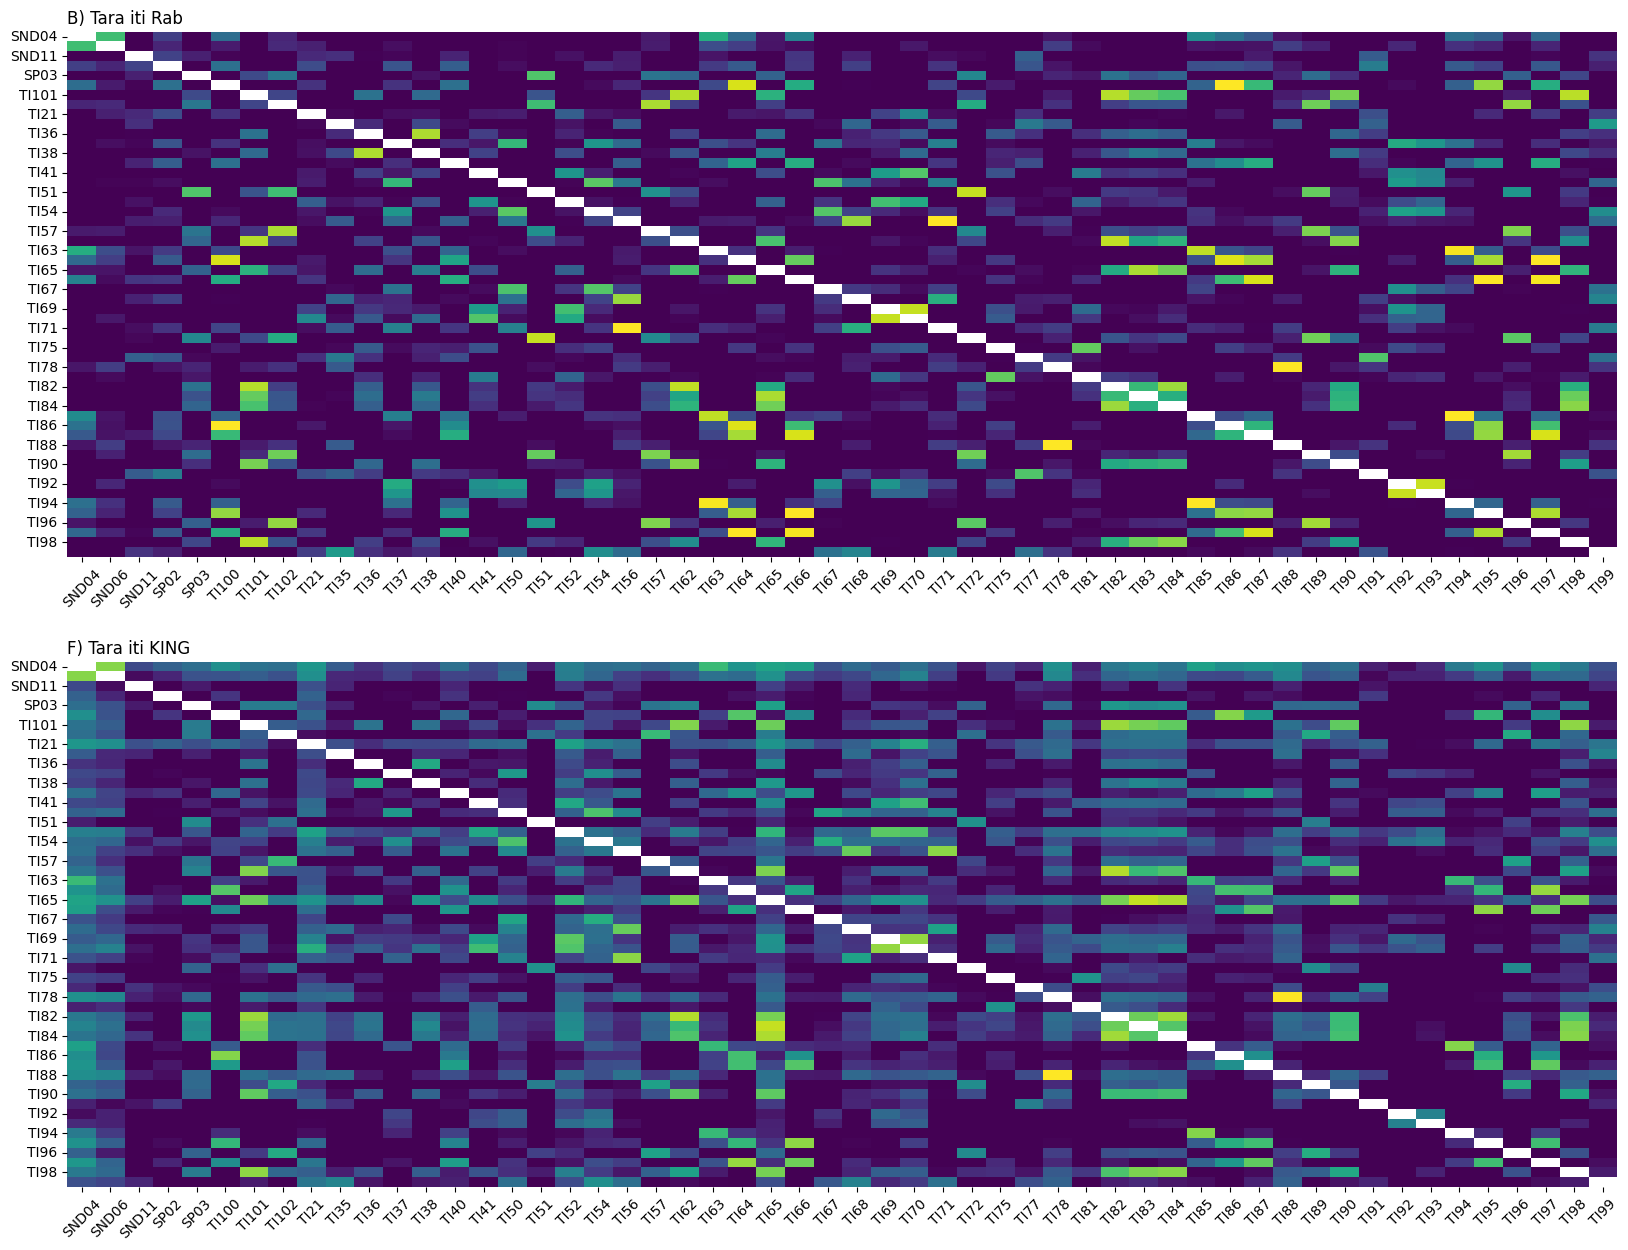

In [3]:
cmap = sns.color_palette('viridis', as_cmap=True)  # Use 'as_cmap=True' to return a colormap

fig, ax = plt.subplots(2, 1, figsize=(20, 15), sharex=False, sharey=False)

sns.heatmap(TI_wg_Rab, annot=False, cmap=cmap, vmin=0, vmax=0.55, cbar=False, ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].set_title('B) Tara iti Rab', loc='left')
ax[0].tick_params(axis='x', rotation=45)
sns.heatmap(TI_wg_KING, annot=False, cmap=cmap, vmin=0, vmax=0.35, cbar=False, ax=ax[1])
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_title('F) Tara iti KING', loc='left')
ax[1].tick_params(axis='x', rotation=45)

It is challenging to quickly identify first order relationships due to the number of samples. Below, we attempt to drop all samples that do not have at least 1 first order relationship and plot only those relationships. 

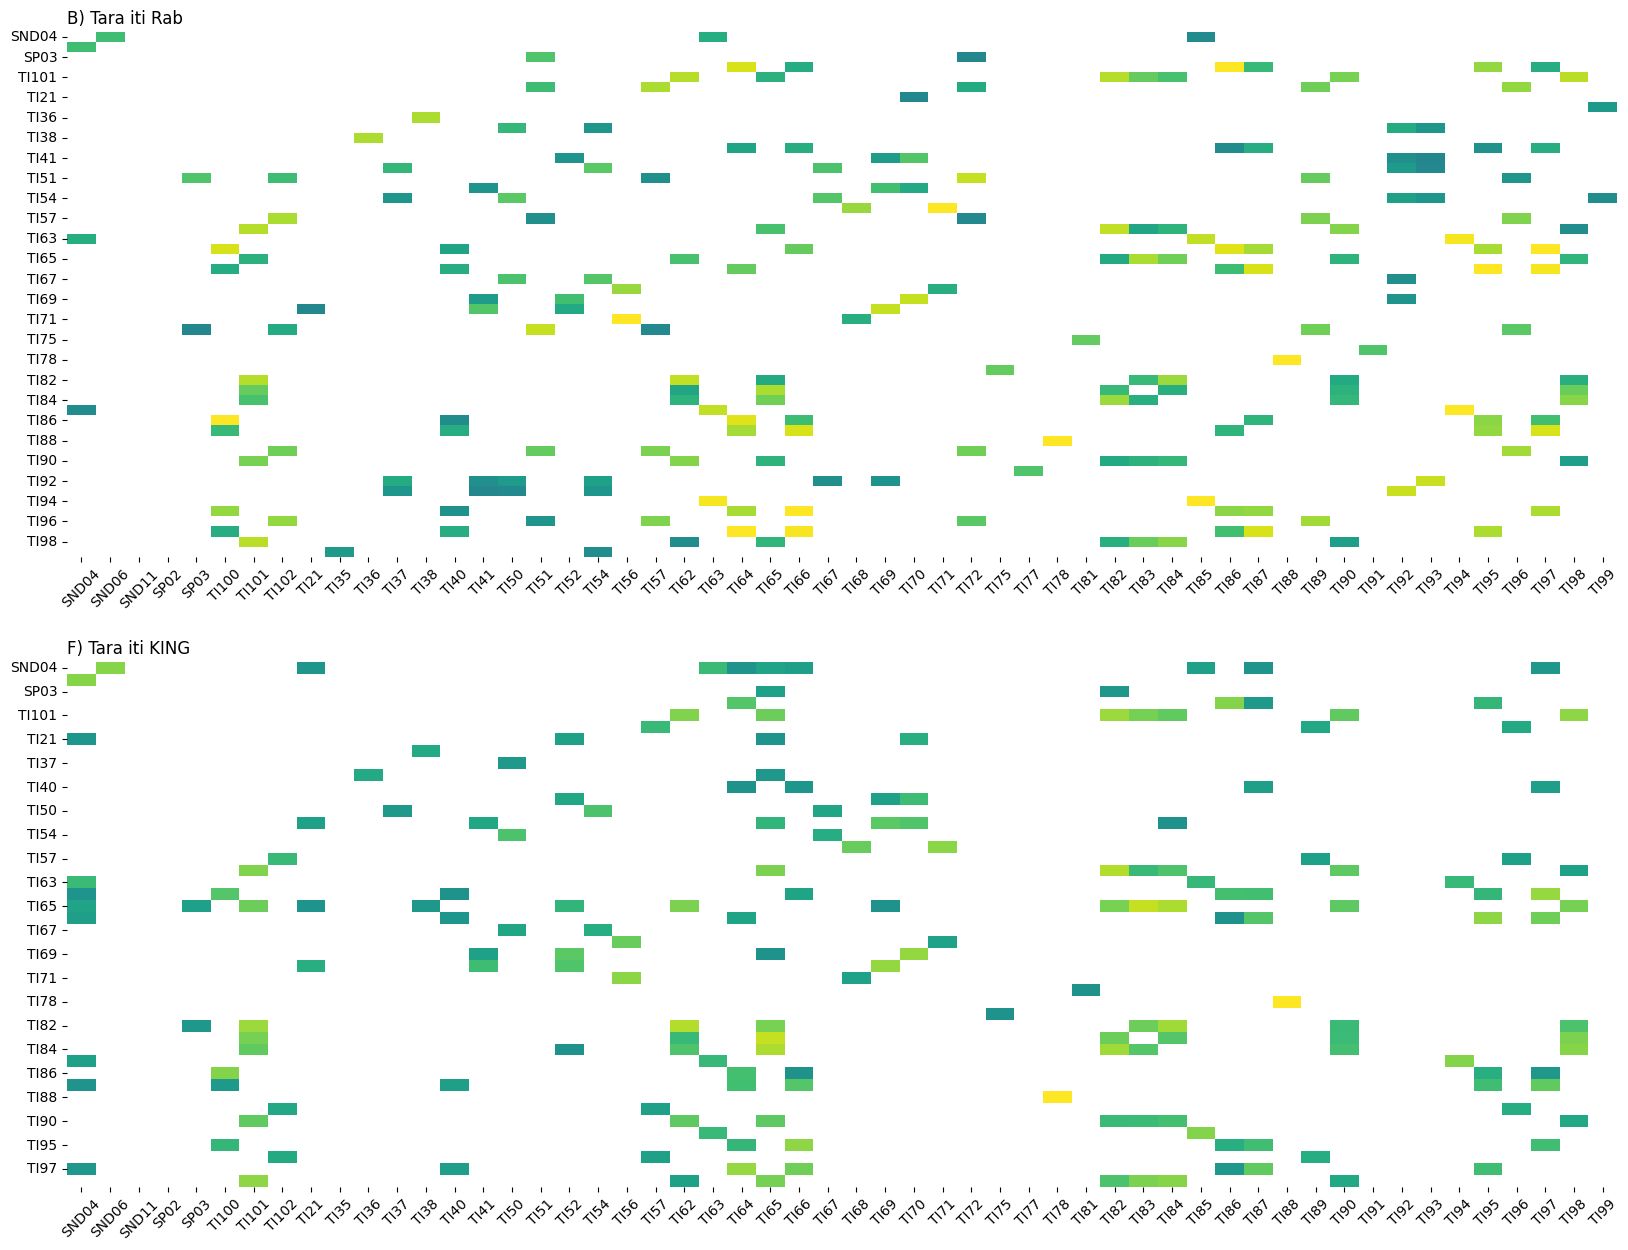

In [11]:
cmap = sns.color_palette('viridis', as_cmap=True)  # Use 'as_cmap=True' to return a colormap

fig, ax = plt.subplots(2, 1, figsize=(20, 15), sharex=False, sharey=False)

sns.heatmap(TI_first_Order_Rab, annot=False, cmap=cmap, vmin=0, vmax=0.55, cbar=False, ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].set_title('B) Tara iti Rab', loc='left')
ax[0].tick_params(axis='x', rotation=45)
sns.heatmap(TI_first_Order_KING, annot=False, cmap=cmap, vmin=0, vmax=0.35, cbar=False, ax=ax[1])
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_title('F) Tara iti KING', loc='left')
ax[1].tick_params(axis='x', rotation=45)

Not great. It seems almost every single of our samples has at least one first order relationship with another individual. This isn't surprising given the extensive inbreeding in the tara iti population. Try and ascertain if some individuals are more related to others, we plot the mean relatedness per individual excluding self-comparisons.  

In the plot below, individuals are plotted as blue dots, with the global realtedness mean plotted as a horizontal red line for both the R<sub>AB</sub> and KING estimators.  

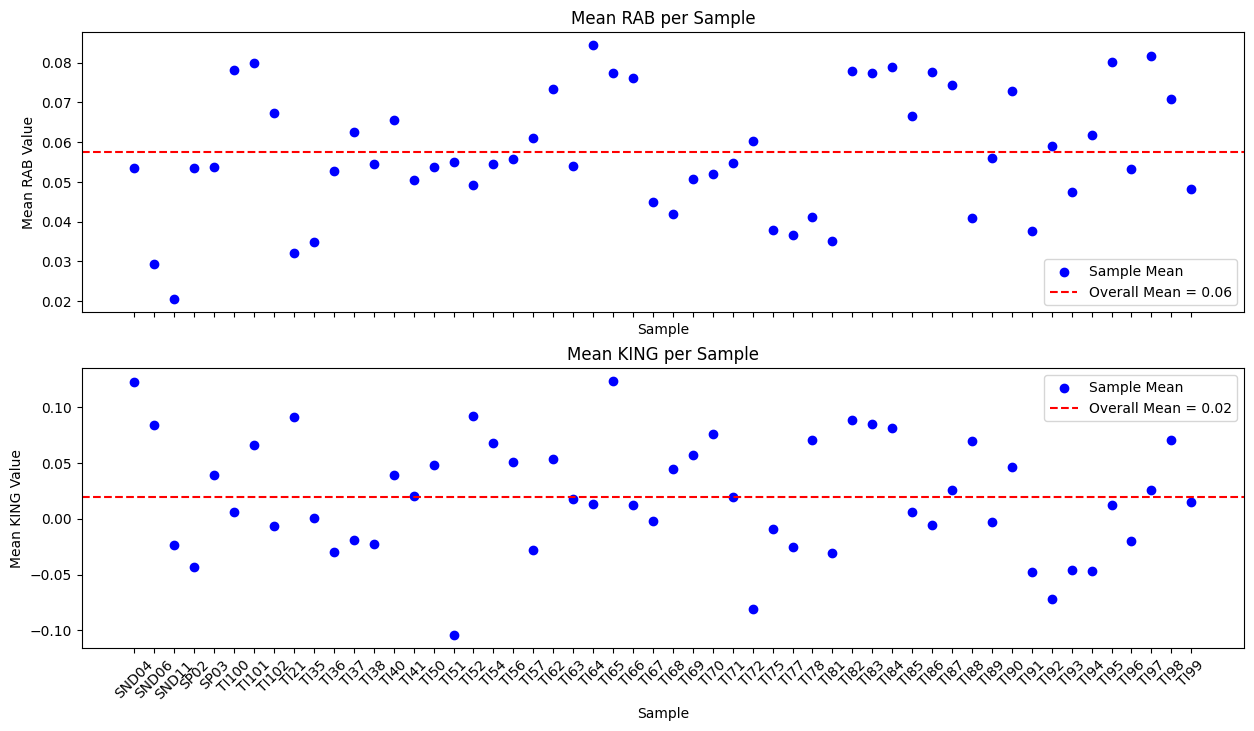

In [4]:
# Replace diagonal with NaN to exclude self-comparisons
TI_rab_no_diag = TI_wg_Rab.copy()
TI_KING_no_diag = TI_wg_KING.copy()

np.fill_diagonal(TI_rab_no_diag.values, np.nan)
np.fill_diagonal(TI_KING_no_diag.values, np.nan)

# Mean for each sample (row)
rab_mean_per_sample = TI_rab_no_diag.mean(axis=1)
KING_mean_per_sample = TI_KING_no_diag.mean(axis=1)

# Overall mean (excluding all NaNs)
rab_overall_mean = TI_rab_no_diag.values[~np.isnan(TI_rab_no_diag.values)].mean()
KING_overall_mean = TI_KING_no_diag.values[~np.isnan(TI_KING_no_diag.values)].mean()

# Plot
fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True, sharey=False)

ax[0].scatter(rab_mean_per_sample.index, rab_mean_per_sample.values, color='blue', label='Sample Mean')
ax[0].axhline(rab_overall_mean, color='red', linestyle='--', label=f'Overall Mean = {rab_overall_mean:.2f}')
ax[0].set_title('Mean RAB per Sample')
ax[0].legend()
ax[0].set_ylabel('Mean RAB Value')
ax[0].set_xlabel('Sample')

ax[1].scatter(KING_mean_per_sample.index, KING_mean_per_sample.values, color='blue', label='Sample Mean')
ax[1].axhline(KING_overall_mean, color='red', linestyle='--', label=f'Overall Mean = {KING_overall_mean:.2f}')
ax[1].set_title('Mean KING per Sample')
ax[1].legend()
ax[1].set_ylabel('Mean KING Value')
ax[1].set_xlabel('Sample')
ax[1].tick_params(axis='x', rotation=45)

As we can see, there's not perfect agreement betweent the two estimators as to who has the highest mean relatedness. Another thing to note is that R<sub>AB</sub> has a mean relatedness value around a third-order relationship for the whole tara iti population, while the mean KING estimate is relatively unrelated. This highlights challenges of relatedness estimators for highly inbred populations more generally ([Hauser et al. 2022](https://doi.org/10.1111/1755-0998.13630)).  

As a final way to explore relatedness in the tara iti population, we counted the number of first-, second- and third-order relationships per sample. Here's the table summarising relatedness values corresponding to pairwise relationships as a reminder.  

|    Relationship   | R<sub>AB</sub> |       KING      |
|:-----------------:|:--------------:|:---------------:|
| Duplicate/MZ Twin |        1       |     > 0.354     |
|     First Order   |  0.250 - 0.500 |  0.177 - 0.354  |
|    Second Order   | 0.1250 - 0.250 | 0.0884 - 0.177  |
|     Third Order   | 0.0600 - 0.125 | 0.0442 - 0.0884 |

In [5]:
# Replace diagonal with NaN to exclude self-comparisons
TI_rab_no_diag = TI_wg_Rab.copy()
TI_KING_no_diag = TI_wg_KING.copy()

np.fill_diagonal(TI_rab_no_diag.values, np.nan)
np.fill_diagonal(TI_KING_no_diag.values, np.nan)

# Third Order Relationships
rab_third_counts = ((TI_rab_no_diag >= 0.06) & (TI_rab_no_diag < 0.125)).sum(axis=1)
king_third_counts = ((TI_KING_no_diag >= 0.0442) & (TI_KING_no_diag < 0.0884)).sum(axis=1)

# Second Order Relationships
rab_second_counts = ((TI_rab_no_diag >= 0.125) & (TI_rab_no_diag < 0.25)).sum(axis=1)
king_second_counts = ((TI_KING_no_diag >= 0.0884) & (TI_KING_no_diag < 0.177)).sum(axis=1)

# First Order Relationships
rab_first_counts = (TI_rab_no_diag >= 0.25).sum(axis=1)
king_first_counts = (TI_rab_no_diag >= 0.177).sum(axis=1)

# Merging all into a single dataframe
interval_counts = pd.concat([
    rab_third_counts.rename('RAB Third Order'),
    rab_second_counts.rename('RAB Second Order') ,
    rab_first_counts.rename('RAB First Order') ,
    king_third_counts.rename('KING Third Order'),
    king_second_counts.rename('KING Second Order'),
    king_first_counts.rename('KING First Order')
], axis=1)

interval_counts_reset = interval_counts.reset_index()
interval_counts_reset = interval_counts_reset.rename(columns={interval_counts_reset.columns[0]: 'Sample'})


long_df = interval_counts_reset.melt(id_vars='Sample', var_name='Metric + Interval', value_name='Count')
long_df[['Method', 'Interval']] = long_df['Metric + Interval'].str.split(' ', n=1, expand=True)

interval_counts.head()

,RAB Third Order,RAB Second Order,RAB First Order,KING Third Order,KING Second Order,KING First Order
ida,,,,,,
SND04,1,8,3,8,29,9
SND06,5,1,1,18,22,1
SND11,5,2,0,7,0,0
SP02,10,10,0,4,2,2
SP03,3,9,2,4,16,7


In [6]:
# Order intervals logically
interval_order = ['Third Order', 'Second Order', 'First Order']
long_df['Interval'] = pd.Categorical(long_df['Interval'], categories=interval_order, ordered=True)

long_df.head()

,Sample,Metric + Interval,Count,Method,Interval
0,SND04,RAB Third Order,1,RAB,Third Order
1,SND06,RAB Third Order,5,RAB,Third Order
2,SND11,RAB Third Order,5,RAB,Third Order
3,SP02,RAB Third Order,10,RAB,Third Order
4,SP03,RAB Third Order,3,RAB,Third Order


First, we examine the number of relationships per individual for R<sub>AB</sub>.  

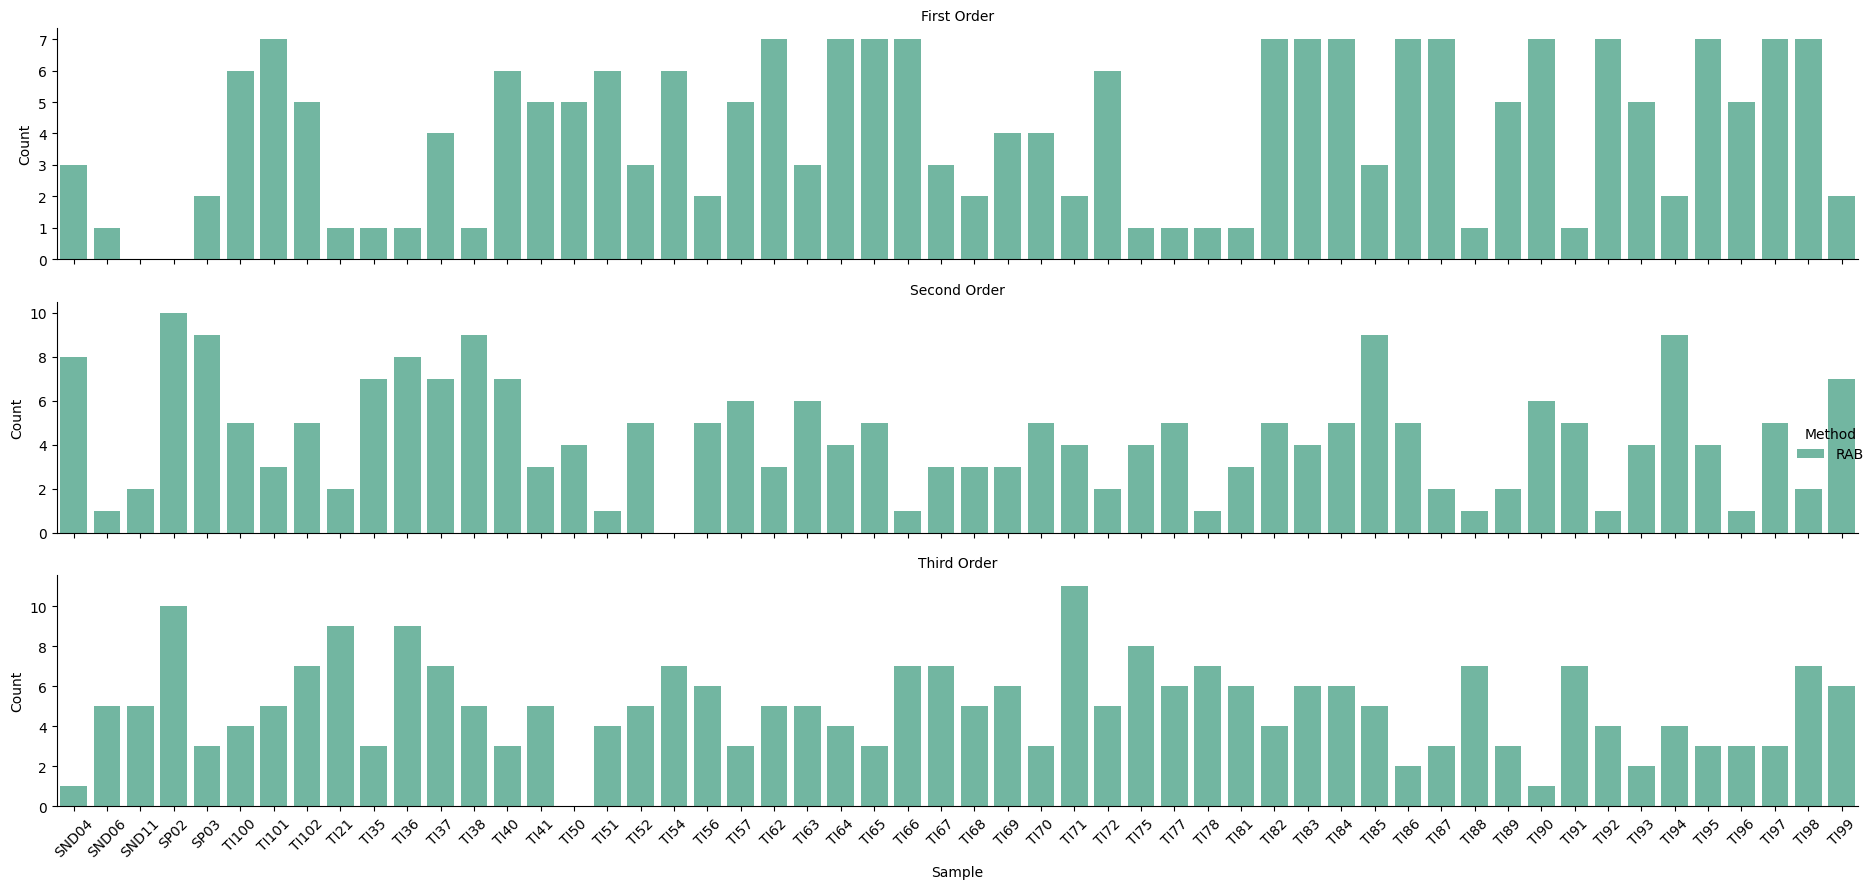

In [15]:
# Optional: set order for cleaner row layout
interval_order = ['First Order', 'Second Order', 'Third Order']
long_df['Interval'] = pd.Categorical(long_df['Interval'], categories=interval_order, ordered=True)

# Plot: vertical facet for each relationship level
g = sns.catplot(
    data=long_df[long_df['Method']=='RAB'],
    kind='bar',
    x='Sample', y='Count', hue='Method',
    row='Interval',  # ← vertical layout by Interval
    palette='Set2',
    sharex=True, sharey=False,  # allows different y-scales
    height=3, aspect=6
)

# Tidy up
g.set_titles("{row_name}")
g.set_axis_labels("Sample", "Count")
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


And here for KING.  

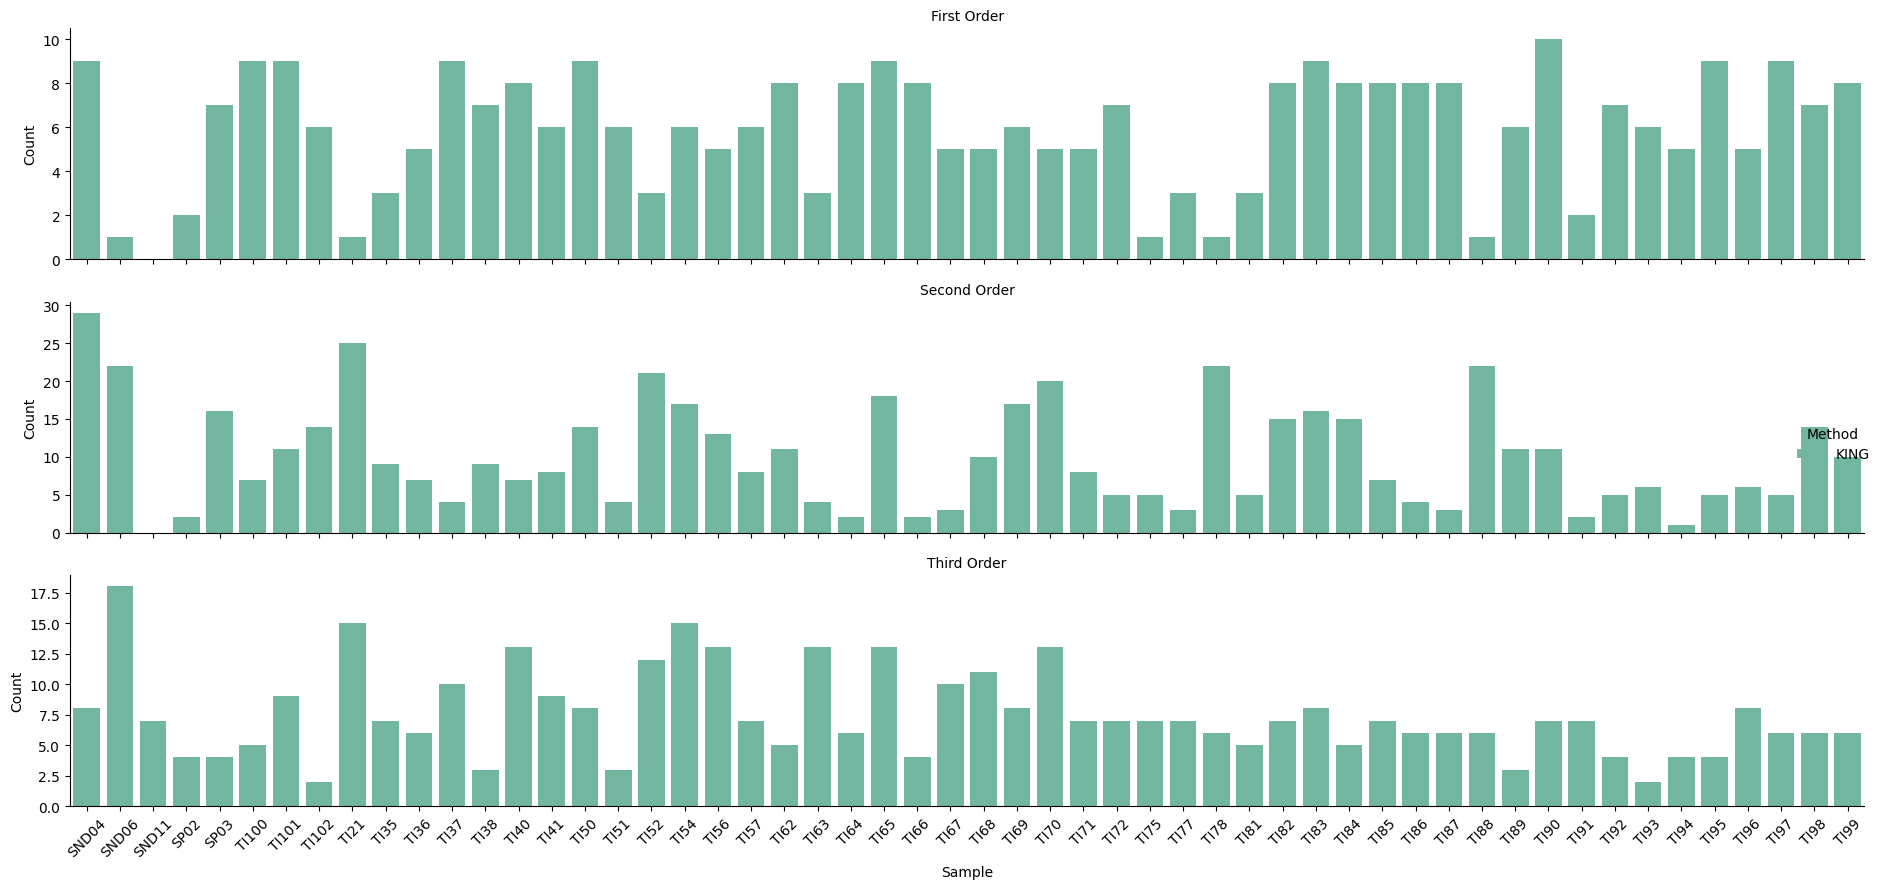

In [16]:
interval_order = ['First Order', 'Second Order', 'Third Order']
long_df['Interval'] = pd.Categorical(long_df['Interval'], categories=interval_order, ordered=True)

# Plot: vertical facet for each relationship level
g = sns.catplot(
    data=long_df[long_df['Method']=='KING'],
    kind='bar',
    x='Sample', y='Count', hue='Method',
    row='Interval',  # ← vertical layout by Interval
    palette='Set2',
    sharex=True, sharey=False,  # allows different y-scales
    height=3, aspect=6
)

# Tidy up
g.set_titles("{row_name}")
g.set_axis_labels("Sample", "Count")
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Briefly, we can see that all but 2 birds have first order relationships with R<sub>AB</sub> estimates, while all but one individual has first order relationships as per KING estimates. Inferences around secong and third order relationships should be treated with some caution given the extensive and pervasive inbreeding and backcrossing recorded in the tara iti population. A table summarising how these estimates relate to pedigreed data from observational records can be found [here](https://docs.google.com/spreadsheets/d/1n2G-3WI_uuqqfsOrefCz6-2HPzI4MMIZdlPw4F1H9sE/edit?usp=sharing).  

## Relatedness of all populations
Here, we estimate relatedness for Australian fairy tern, tara iti, and kakī populations for the supplemental material.  

In [ ]:
# put the ANGSD code I used for the filtered TI pop, AU, and KI sample sets.  

Summary of sites analysed and retained for each of the populations. 

| Data Set | Total Sites Analysed | Number Sites Retained |
|:--------:|:--------------------:|:---------------------:|
|    AU    |     1,139,822,001    |       1,488,012       |
|    TI    |     1,195,028,924    |        4XX,XXX        |
|    KI    |     1,091,298,689    |       1,633,184       |
|  KI 10x  |     1,090,608,686    |       1,302,423       |

Below we load the relevant files for visualisation.  

In [4]:
AU_wg = pd.read_csv('angsd/samtools/relatedness/AU_whole-genome_relatedness', sep='\t')
TI_wg = pd.read_csv('angsd/samtools/relatedness/TI_whole-genome_relatedness', sep='\t')
KI_wg = pd.read_csv('angsd/samtools/relatedness/KI_whole-genome_relatedness', sep='\t')
KI10x_wg = pd.read_csv('angsd/samtools/relatedness/KI_10x_whole-genome_relatedness', sep='\t')

AU_full = pd.concat([AU_wg, AU_wg.rename(columns={'ida': 'idb', 'idb': 'ida'})])
TI_full = pd.concat([TI_wg, TI_wg.rename(columns={'ida': 'idb', 'idb': 'ida'})])
KI_full = pd.concat([KI_wg, KI_wg.rename(columns={'ida': 'idb', 'idb': 'ida'})])
KI10x_full = pd.concat([KI10x_wg, KI10x_wg.rename(columns={'ida': 'idb', 'idb': 'ida'})])

AU_wg_Rab = AU_full.pivot(index='ida', columns='idb', values='rab')
TI_wg_Rab = TI_full.pivot(index='ida', columns='idb', values='rab')
KI_wg_Rab = KI_full.pivot(index='ida', columns='idb', values='rab')
KI10x_wg_Rab = KI10x_full.pivot(index='ida', columns='idb', values='rab')

AU_wg_KING = AU_full.pivot(index='ida', columns='idb', values='KING')
TI_wg_KING = TI_full.pivot(index='ida', columns='idb', values='KING')
KI_wg_KING = KI_full.pivot(index='ida', columns='idb', values='KING')
KI10x_wg_KING = KI10x_full.pivot(index='ida', columns='idb', values='KING')

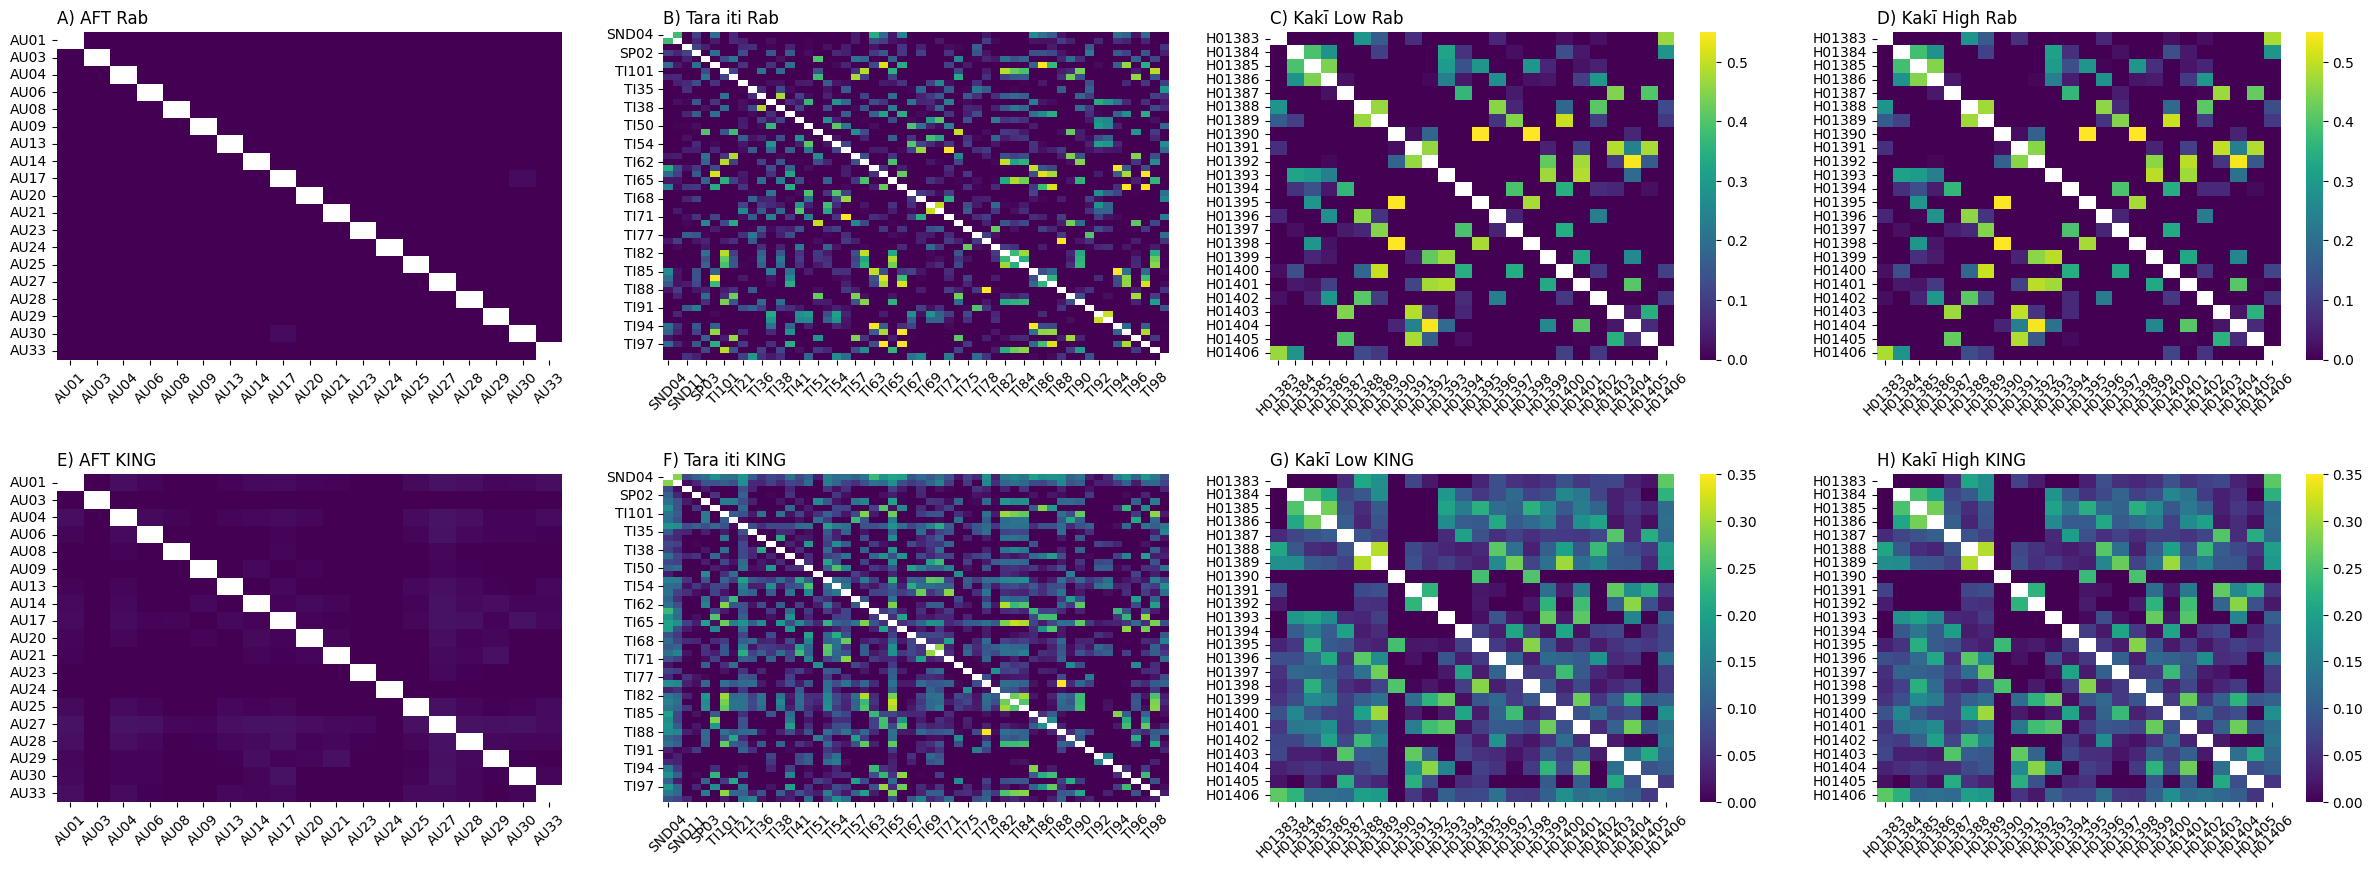

In [5]:
# Create a custom color map from seaborn
cmap = sns.color_palette('viridis', as_cmap=True)  # Use 'as_cmap=True' to return a colormap

fig, ax = plt.subplots(2, 4, figsize=(30, 10), sharex=False, sharey=False)

sns.heatmap(AU_wg_Rab, annot=False, cmap=cmap, vmin=0, vmax=0.55, cbar=False, ax=ax[0,0])
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('')
ax[0,0].set_title('A) AFT Rab', loc='left')
ax[0,0].tick_params(axis='x', rotation=45)
sns.heatmap(AU_wg_KING, annot=False, cmap=cmap, vmin=0, vmax=0.35, cbar=False, ax=ax[1,0])
ax[1,0].set_xlabel('')
ax[1,0].set_ylabel('')
ax[1,0].set_title('E) AFT KING', loc='left')
ax[1,0].tick_params(axis='x', rotation=45)
sns.heatmap(TI_wg_Rab, annot=False, cmap=cmap, vmin=0, vmax=0.55, cbar=False, ax=ax[0,1])
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('')
ax[0,1].set_title('B) Tara iti Rab', loc='left')
ax[0,1].tick_params(axis='x', rotation=45)
sns.heatmap(TI_wg_KING, annot=False, cmap=cmap, vmin=0, vmax=0.35, cbar=False, ax=ax[1,1])
ax[1,1].set_xlabel('')
ax[1,1].set_ylabel('')
ax[1,1].set_title('F) Tara iti KING', loc='left')
ax[1,1].tick_params(axis='x', rotation=45)
sns.heatmap(KI10x_wg_Rab, annot=False, cmap=cmap, vmin=0, vmax=0.55, cbar=True, ax=ax[0,2])
ax[0,2].set_xlabel('')
ax[0,2].set_ylabel('')
ax[0,2].set_title('C) Kakī Low Rab', loc='left')
ax[0,2].tick_params(axis='x', rotation=45)
sns.heatmap(KI10x_wg_KING, annot=False, cmap=cmap, vmin=0, vmax=0.35, cbar=True, ax=ax[1,2])
ax[1,2].set_xlabel('')
ax[1,2].set_ylabel('')
ax[1,2].set_title('G) Kakī Low KING', loc='left')
ax[1,2].tick_params(axis='x', rotation=45)
sns.heatmap(KI_wg_Rab, annot=False, cmap=cmap, vmin=0, vmax=0.55, cbar=True, ax=ax[0,3])
ax[0,3].set_xlabel('')
ax[0,3].set_ylabel('')
ax[0,3].set_title('D) Kakī High Rab', loc='left')
ax[0,3].tick_params(axis='x', rotation=45)
sns.heatmap(KI_wg_KING, annot=False, cmap=cmap, vmin=0, vmax=0.35, cbar=True, ax=ax[1,3])
ax[1,3].set_xlabel('')
ax[1,3].set_ylabel('')
ax[1,3].set_title('H) Kakī High KING', loc='left')
ax[1,3].tick_params(axis='x', rotation=45)

plt.subplots_adjust(hspace=0.35)

#plt.savefig('plots/Supp_Fig_whole-genome_relatedness.png', dpi=300, bbox_inches='tight')